<a href="https://colab.research.google.com/github/mariannaflores/final_eml/blob/main/proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto Final - Machine Learning Models
## MODELO DE PREDICCION DE NOMBRE SEGUN COLOR DE PINTURA DE UNAS

#### LIBRERIAS

In [1]:
pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Preparacion de variables
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Modelos de neural networks
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import activations
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

### DEFINICION PROYECTO

**NECESIDAD:** Usualmente a uno le gusta usar pinturas de uñas de colores similares o cierta gama particular, pero es altamente complicado pues los nombres parecen no tener sentido o relacion con el color.

**OBJETIVO PROYECTO:** Desarrollar un sistema de recomendacion que al ingresar una categoria o rama de colores recomiende los mas populares o los mas similares a el color.

**METODOLOGIA:** Uso de redes neurales para optimizar las relaciones entre los datos de los colores, que suelen ser muy complejos y desarrollar dos modelos.
  1. Recomendacion por popularidad de color   2. Recomendacion por codigo de color.

#### TEORIA DE COLOR

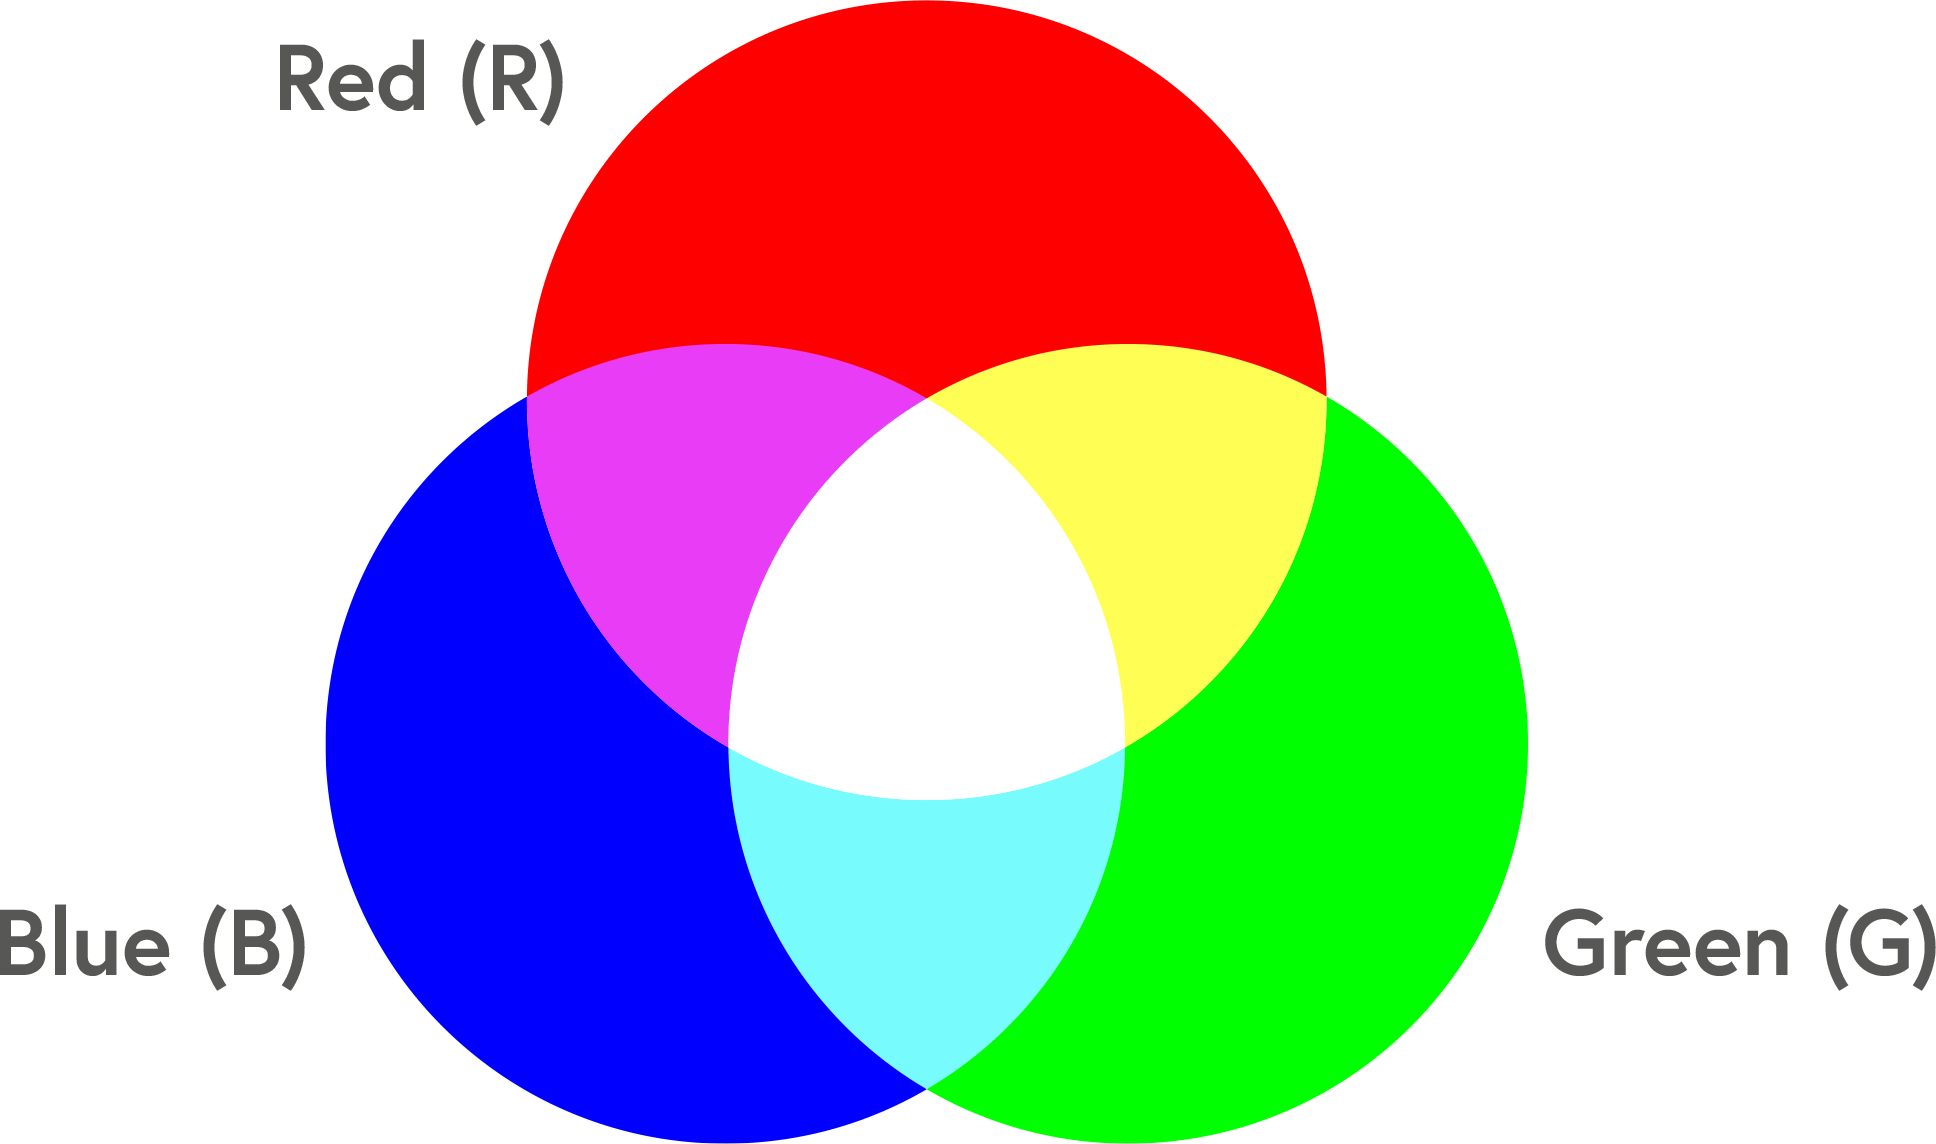

Hay distintas escalas de color que se definen distinto segun el color base y los componentes que se considera.
En el siguiente proyecto se manejo la escala de color RGB, esta consiste de 3 componentes. El tope es de 255 (el color mas puro). 
1. Rojo - R
2. Green - G
3. Blue - B
* Los otros colores son definidos como la combinacion de R, G,B que lo conforma.
* Blanco es 255 en los tres componentes
* Negro es 0 en los tres componentes


### UPLOAD DATASET

In [3]:
#df = pd.read_csv('/Users/maria/OneDrive/Documentos/mle_laboratorios/Final/final_eml/dataset.csv')
#df.head()

#from google.colab import files
#uploaded = files.upload()

#import io
#df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
#df.head()

In [4]:
url = 'https://raw.githubusercontent.com/mariannaflores/final_eml/main/dataset.csv'
df = pd.read_csv(url)
df.head()

,name,type,score,raitings,hex,rgb,category,marca
0,sheer luck,classic,5.0,3.0,#f4e1e8,"rgb(244,225,225)",sheers,essie
1,always transparent,exprclassic,0.0,0.0,#fafbf8,"rgb(250,251,251)",sheers,essie
2,tuck it in my tux,classic,3.4,15.0,#f5f1ee,"rgb(245,241,241)",sheers,essie
3,desk mani,exprclassic,0.0,0.0,#f78963,"rgb(247,137,137)",sheers,essie
4,marshmallow,classic,4.4,83.0,#f1e6e3,"rgb(240,228,228)",sheers,essie


In [5]:
df.dtypes

name         object
type         object
score       float64
raitings    float64
hex          object
rgb          object
category     object
marca        object
dtype: object

Se separa categoria y marca para agregar a la matriz de recomendacion despues

In [6]:
categ = df[['category','marca']]

### PREPROCESADO

#### PREPARACION COLUMNA CODIGO RGB

La columna de rgb tiene que procesarse separando por cada componente de color (red, green, blue)

In [7]:
codigo = df["rgb"]

remove = ['rgb']
remove2 = ['(']
remove3 = [')']

for i in remove:
    s1 = codigo.str.replace(i, '')

for j in remove2:
    s2 = s1.str.replace(j, '')


for k in remove3:
    s3 = s2.str.replace(k, '')

colores = s3.str.split(",", n = 2, expand = True)
colores.head()

,0,1,2
0,244,225,225
1,250,251,251
2,245,241,241
3,247,137,137
4,240,228,228


In [8]:
df = df.drop(['rgb'], axis=1)
df = pd.concat([df, colores], axis=1)
df = df.rename({0:"r", 1:"g", 2:"b"}, axis='columns')

Se agrega indice para identificar cada pintura de uñas en el analisis de la red neuronal

In [9]:
df['index'] = df.index

#### ENCODING VARIABLES CATEGORICAS

Se emplea *encoding ordinal* para mantener una sola columna con los valores de cada columna

In [10]:
ce_ord = ce.OrdinalEncoder(cols = ['type', 'category', 'marca'])
df = ce_ord.fit_transform(df)
df.head()

,name,type,score,raitings,hex,category,marca,r,g,b,index
0,sheer luck,1,5.0,3.0,#f4e1e8,1,1,244,225,225,0
1,always transparent,2,0.0,0.0,#fafbf8,1,1,250,251,251,1
2,tuck it in my tux,1,3.4,15.0,#f5f1ee,1,1,245,241,241,2
3,desk mani,2,0.0,0.0,#f78963,1,1,247,137,137,3
4,marshmallow,1,4.4,83.0,#f1e6e3,1,1,240,228,228,4


### PESOS PARA VALUAR MATRIZ POR RATING Y POR COLOR

Para poder medir tanto en ratings como por color es necesario establecer una metrica.
Se definieron dos modelos segun la informacion obtenida en el dataset:
1. **Ratings:** las paginas web de pinturas de uñas tenian ratings de usuarios previos que se usaron como metodo de medicion para recomendar nuevas pinturas de uñas de distintas categorias
2. **Codigo de color:** El codigo de color como tal es muy extenso y complejo para analizar, por ende se realizo una metrica compuesto de los 3 colores.
Ecuacion: rrr + ggg00 + bbb0000, los colores mas rojos seran mas pequeños y entre mas azules mas grandes.

In [11]:
#pesos de ratings por clientes y colores de pintura
m=df['raitings'].quantile(0.9)
C=df['score'].mean()

def peso_scores(x, m=m, C=C):
    v = x['raitings']
    R = x['score']
    return (v/(v+m) * R) + (m/(m+v) * C)

df['weight'] = df.apply(peso_scores, axis=1)

In [12]:
#metrica de cada color por presencia de colores
df['r'] = df['r'].astype(int)
df['g'] = df['g'].astype(int)
df['b'] = df['b'].astype(int)

df['color'] = df['r'] + df['g']*100 + df['b']*10000

### EXPLORACION DATOS

In [13]:
df.describe()

,type,score,raitings,category,marca,r,g,b,index,weight,color
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1.010000e+03
mean,2.112871,3.680792,257.292079,6.419802,1.798020,170.150495,119.715842,119.742574,504.500000,3.793494,1.209567e+06
std,1.440299,1.736362,810.858204,3.075850,0.864907,70.000065,70.144841,70.123387,291.706188,0.142630,7.082867e+05
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.308400,0.000000e+00
25%,1.000000,4.000000,1.000000,4.000000,1.000000,128.000000,57.250000,58.250000,252.250000,3.683864,5.883985e+05
50%,1.000000,4.300000,8.500000,6.000000,2.000000,193.000000,123.000000,123.000000,504.500000,3.744495,1.242500e+06
75%,3.000000,4.900000,38.000000,8.000000,3.000000,227.000000,179.750000,179.750000,756.750000,3.867623,1.815688e+06
max,6.000000,5.000000,3018.500000,14.000000,3.000000,255.000000,255.000000,255.000000,1009.000000,4.488655,2.575755e+06


In [14]:
categ.category.value_counts()

pinks      202
purples    151
blues      117
nudes      108
reds        97
grays       75
greens      56
corals      51
whites      38
browns      33
sheers      26
oranges     25
yellows     18
blacks      13
Name: category, dtype: int64

Graficos del dataset

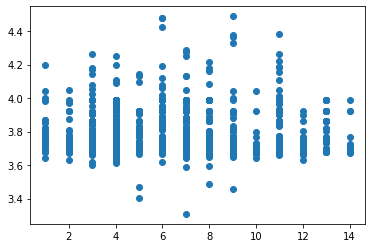

In [15]:
#Distribucion de pinturas de uñas por categoria y peso de cada rating 
plt.scatter(df.category, df.weight)
plt.show()

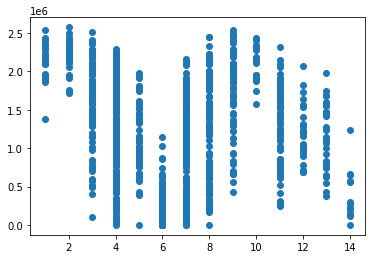

In [16]:
#Distribucion de pinturas de uñas por categoria y pureza de los colores
plt.scatter(df.category, df.color)
plt.show()

### SEPARACION DE VARIABLES X Y Y 

Se separaron las variables dos veces por los dos modelos empleados, uno con peso de ratings y otro con codigo de color.
> Se normalizo la variable "y" por medio del minimo y maximo para manejar datos entre 0 y 1 para el entrenamiento


In [17]:
min1 = min(df["weight"])
max1 = max(df["weight"])

x1 = df[["category", "index"]].values
y1 = df["weight"].apply(lambda x: (x - min1) / (max1 - min1)).values

x_train1, x_cv1, x_test1 = np.split(x1, 
                       [int(.3333*len(x1)), int(.6666*len(x1))])
y_train1, y_cv1, y_test1 = np.split(y1, 
                       [int(.3333*len(y1)), int(.666*len(y1))])

y_test1 = y_test1[0:336]
x_cv1 = x_cv1[0:336]
x_test1 = x_test1[0:336]

In [18]:
min2 = min(df["color"])
max2 = max(df["color"])

x2 = df[["category", "index"]].values
y2 = df["color"].apply(lambda x: (x - min2) / (max2 - min2)).values

x_train2, x_cv2, x_test2 = np.split(x2, 
                       [int(.3333*len(x2)), int(.6666*len(x2))])
y_train2, y_cv2, y_test2 = np.split(y2, 
                       [int(.3333*len(y2)), int(.666*len(y2))])

y_test2 = y_test2[0:336]
x_cv2 = x_cv2[0:336]
x_test2 = x_test2[0:336]

### PREPARACION MATRICES MODELOS

Para poder ingresar al modelo los componentes se tiene que separar segun lo necesario.<br>
Para el modelo 1: categoria, indice y peso de los ratings <br>
Para el modelo 2: categoria, indice y el codigo de color <br>
Y finalmente un ultimo dataset con los datos de cada pintura de uñas por concatenar en los resultados


In [19]:
df1 = df[['category','index','weight']] #para modelo1
df2 = df[['category', 'index', 'color']] #para modelo2
info_np = df[['index','name']] 
info_np = pd.concat([info_np, categ], axis = 1) #matriz con informacion por item para resultados

### FUNCIONES REDES NEURALES

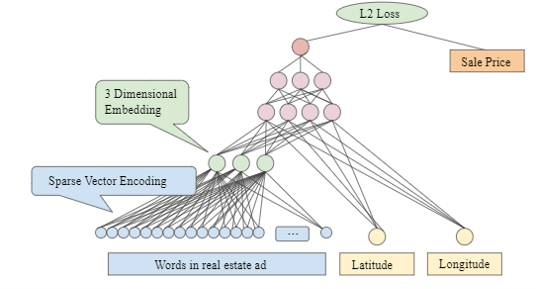 <br>
La [imagen](https://https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) anterior ejemplifica el esquema que se empleo para el modelo de recomendacion (aunque cuenta con datos de real estate), por medio de embedding y layers de activacion. <br>
<br>

**Proceso redes neurales**
*   **Embedding:** Se creo una capa de embedding para los usuarios (categorias o colores) y una para los items (cada pintura de uñas). Estos son agregados como las primeras dos capas para vectorizar los inputs.
*   **Funcion activacion - sigmoide:** sigmoid(x) = 1 / (1 + exp(-x))
*   **Loss - mean_squared_error:** cantidad que el modelo debe minimizar en training. Este encuentra el cuadrado de la diferencia entre el las predicciones y observaciones reales.
*   **Optimizer - Adam:** algoritmo optimizador de stochastic gradient descent.
*   **Bias:** constante de input para as dos capas de embedding.



#### FUNCION CREAR MODELO

In [20]:
class RecommenderNet(keras.Model):
    def __init__(self, usuario, items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.usuario = usuario
        self.items = items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            usuario,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(usuario, 1)
        self.item_embedding = layers.Embedding(
            items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(items, 1)

    def call(self, inputs):
        user_bias = self.user_bias(inputs[:, 0])
        item_bias = self.item_bias(inputs[:, 1])
        user_vector = self.user_embedding(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        prod_punto = tf.tensordot(user_vector, item_vector, 2)
        x = prod_punto + user_bias + item_bias
        x = activations.sigmoid(x)
        return (x)


### MODELO 1 - SISTEMA DE RECOMENDACION BASADO EN CATEGORIAS DE COLORES

In [21]:
categoria = df['category'].nunique()+1
pinturas = df['index'].nunique()

In [22]:
model = RecommenderNet(categoria, pinturas, 50)
model.compile(
    loss='mean_squared_error', optimizer=Adam(lr=0.001)
)

Se usaron 500 epochs para asegurar que bajara el loss del training y test set al minimo posible, el batch_size esta en 10 para asegurar que use multiples datos.

In [23]:
history = model.fit(
    x=x_train1,
    y=y_train1,
    batch_size=10,
    epochs=500,
    verbose=1,
    validation_data=(x_cv1, y_cv1),
)

Epoch 1/500
34/34 [==============================] - 2s 21ms/step - loss: 0.0405 - val_loss: 0.0342
Epoch 2/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0327
Epoch 3/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0314
Epoch 4/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0204 - val_loss: 0.0304
Epoch 5/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0298
Epoch 6/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0232 - val_loss: 0.0293
Epoch 7/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0290
Epoch 8/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0288
Epoch 9/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0286
Epoch 10/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0286
Epoch 11

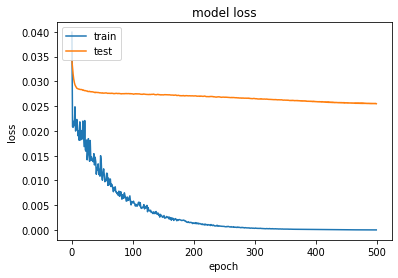

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

No cae tanto el test set pero sigue siendo bastante bajo, el rendimiento general del modelo es bueno

#### DEFINIR COMPONENTES NEURAL NETWORK 1

In [25]:
user_ids = df1["category"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

items_ids = df1["index"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(items_ids)}
item_encoded2item = {i: x for i, x in enumerate(items_ids)}

#### TESTING MODELO 1

**Categorias**
1. sheers
2. whites
3. nudes 
4. pinks 
5. corals 
6. reds 
7. purples
8. blues 
9. greens 
10. yellows 
11. grays 
12. oranges 
13. browns
14. blacks <br>
Las siguientes categorias son seleccionadas random para obtener recomendaciones basadas en ratings y colores

In [26]:
#numero de categoria random o seleccionado
cat = df.category.sample(1).iloc[0]

In [27]:
np_category = df[df.category == cat]
np_not_category = info_np[
    ~info_np["index"].isin(np_category.index.values)
]["index"]
np_not_category = list(
    set(np_not_category).intersection(set(item2item_encoded.keys()))
)
np_not_category = [[item2item_encoded.get(x
)] for x in np_not_category]
user_encoder = user2user_encoded.get(cat)
user_item_array = np.hstack(
    ([[user_encoder]] * len(np_not_category), np_not_category)
)

ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(np_not_category[x][0]) for x in top_ratings_indices
]

print("Mas recomendadas categoria: {}".format(cat))
print("---" * 20)
top_np_user = (
    np_category.sort_values(by="weight", ascending=False)
    .head(5)
    .index.values
)
info_np1 = info_np[info_np["index"].isin(top_np_user)]
for row in info_np1.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

print(" " * 35)
print(" " * 35)
print("Top 10 recomendaciones")
print("---" * 20)
recommended_nailpolish = info_np[info_np["index"].isin(recommended_item_ids)]
for row in recommended_nailpolish.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)

Mas recomendadas categoria: 4
------------------------------------------------------------
ballet slippers remixed | categoria: pinks  | marca: essie
fiji | categoria: pinks  | marca: essie
fairy tailor | categoria: pinks  | marca: essie
watermelon | categoria: pinks  | marca: essie
frill seeker | categoria: pinks  | marca: sally hansen
                                   
                                   
Top 10 recomendaciones
------------------------------------------------------------
ballet slippers | categoria: sheers  | marca: essie
lady like | categoria: nudes  | marca: essie
pinned up | categoria: nudes  | marca: essie
princess charming | categoria: nudes  | marca: essie
couture curator  | categoria: corals  | marca: essie
cute as a button | categoria: corals  | marca: essie
seize the minute | categoria: reds  | marca: essie
wicked | categoria: reds  | marca: essie
wicked remix | categoria: reds  | marca: essie
play date | categoria: purples  | marca: essie


### MODELO 2 - SISTEMA DE RECOMENDACION BASADO EN CODIGO RGB

In [28]:
categoria = df['color'].nunique()+1
pinturas = df['index'].nunique()

In [29]:
model = RecommenderNet(categoria, pinturas, 50)
model.compile(
    loss='mean_squared_error', optimizer=Adam(lr=0.001)
)

In [30]:
history = model.fit(
    x=x_train2,
    y=y_train2,
    batch_size=10,
    epochs=500,
    verbose=1,
    validation_data=(x_cv2, y_cv2),
)

Epoch 1/500
34/34 [==============================] - 1s 10ms/step - loss: 0.0903 - val_loss: 0.0664
Epoch 2/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0898 - val_loss: 0.0663
Epoch 3/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0777 - val_loss: 0.0660
Epoch 4/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0801 - val_loss: 0.0659
Epoch 5/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0807 - val_loss: 0.0658
Epoch 6/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0767 - val_loss: 0.0657
Epoch 7/500
34/34 [==============================] - 0s 4ms/step - loss: 0.0731 - val_loss: 0.0656
Epoch 8/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0650 - val_loss: 0.0656
Epoch 9/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0701 - val_loss: 0.0655
Epoch 10/500
34/34 [==============================] - 0s 5ms/step - loss: 0.0700 - val_loss: 0.0655
Epoch 11

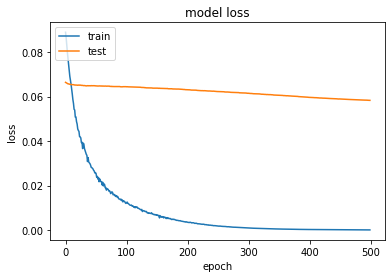

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

El loss del segundo modelo tiene un peor rendimiento que el modelo previo

#### DEFINIR COMPONENTES NEURAL NETWORK 2

Se puede usar un color random o ingresar un nombre (donde dice marshmallow) si se busca en base a una pintura especifica

In [45]:
#numero de categoria random o seleccionado
col = df.color.sample(1).iloc[0]

#instancia = df.loc[df['name'] == 'shock wave']
#col = instancia['color'].iloc[0]

In [46]:
user_ids = df2["color"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

items_ids = df2["index"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(items_ids)}
item_encoded2item = {i: x for i, x in enumerate(items_ids)}

#### TESTING MODELO 2

In [47]:
top = col+500
bot = col-500

np_category = df[(df.color >= bot) & (df.color <= top)]
np_not_category = info_np[
    ~info_np["index"].isin(np_category.index.values)
]["index"]
np_not_category = list(
    set(np_not_category).intersection(set(item2item_encoded.keys()))
)
np_not_category = [[item2item_encoded.get(x
)] for x in np_not_category]
user_encoder = user2user_encoded.get(col)
user_item_array = np.hstack(
    ([[user_encoder]] * len(np_not_category), np_not_category)
)

In [48]:
ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(np_not_category[x][0]) for x in top_ratings_indices
]

print("Mas recomendadas categoria: {}".format(col), )
print("---" * 20)
top_np_user = (
    np_category.sort_values(by="color", ascending=False)
    .head(5)
    .index.values
)
info_np1 = info_np[info_np["index"].isin(top_np_user)]
for row in info_np1.itertuples():
    print(row.name, "| categoria:", row.category," | marca:" ,row.marca)


Mas recomendadas categoria: 272919
------------------------------------------------------------
without reservations | categoria: purples  | marca: essie
dutch tulipa | categoria: pinks  | marca: opi
pampered in pink | categoria: pinks  | marca: sally hansen
cherry red | categoria: reds  | marca: sally hansen
bordeaux glow | categoria: purples  | marca: sally hansen


In [49]:
#Confirmacion de funcionamiento de algoritmo por el color de la busqueda
df.loc[df['color'] == col]

,name,type,score,raitings,hex,category,marca,r,g,b,index,weight,color
512,dutch tulipa,1,4.7,6.0,#db1b4f,4,2,219,27,27,512,3.736947,272919


### CONCLUSIONES

* El modelo 1 de recomendacion por ratings tiene un mejor rendimieto que el segundo.
* El modelo 2 da resultados concretos directamente de un color de pintura de uñas por lo que es mas complejo y depende de la cercania de otros factores cuantas recomendaciones tiene disponible (de algunos colores hay pocas observaciones).
* Distintos modelos enfocados a las distintas necesidades
 * Identificar mejores productos de cada categoria por medio de ratings
 * Identificar productos mas cercanos a color buscado por medio de codigo de color
* Inicialmente no se tenian suficientes datos (se identifico bias) que al incrementar los datos se elimino
* Aplicable a toda la industria de belleza y maquillaje

### RECOMENDACIONES
* De algunas categorias hay muy pocas observaciones, por lo que las predicciones no son tan confiables.
* Datasets unicamente de una empresa podria ser mas viable para la implementacion en una empresa real (aunque ninguna cuenta con suficientes colores).
* Encontrar otras fuentes de ratings (como las pinturas tambien son vendidas en super mercados, amazon, etc).



### REFERENCIAS

> Guias para desarrollo de sistema de recomendacion con redes neurales, funciones de activacion, optimizer, etc.  <br>

https://keras.io/guides/

<br>

> Creo un generador de nombres de pinturas de uñas segun codigo de color. En el articulo explica la teoria de color y su aplicacion a la industria del maquillaje. <br>

Organ, N. (2021, January 27). The Color Theory of Nail Polish Names. <br>
https://medium.com/nightingale/the-color-theory-of-nail-polish-names-fa428610b443

